Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [2]:
import pandas as pd
url = "http://bit.ly/2IgDF0E"
df_voles = pd.read_csv(url)
print(df_voles.head())

   site  voles  veg   soil
0     1     17    4  moist
1     2     30   33  moist
2     3     54   94  moist
3     4     49   64  moist
4     5     34   32  moist


Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [3]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

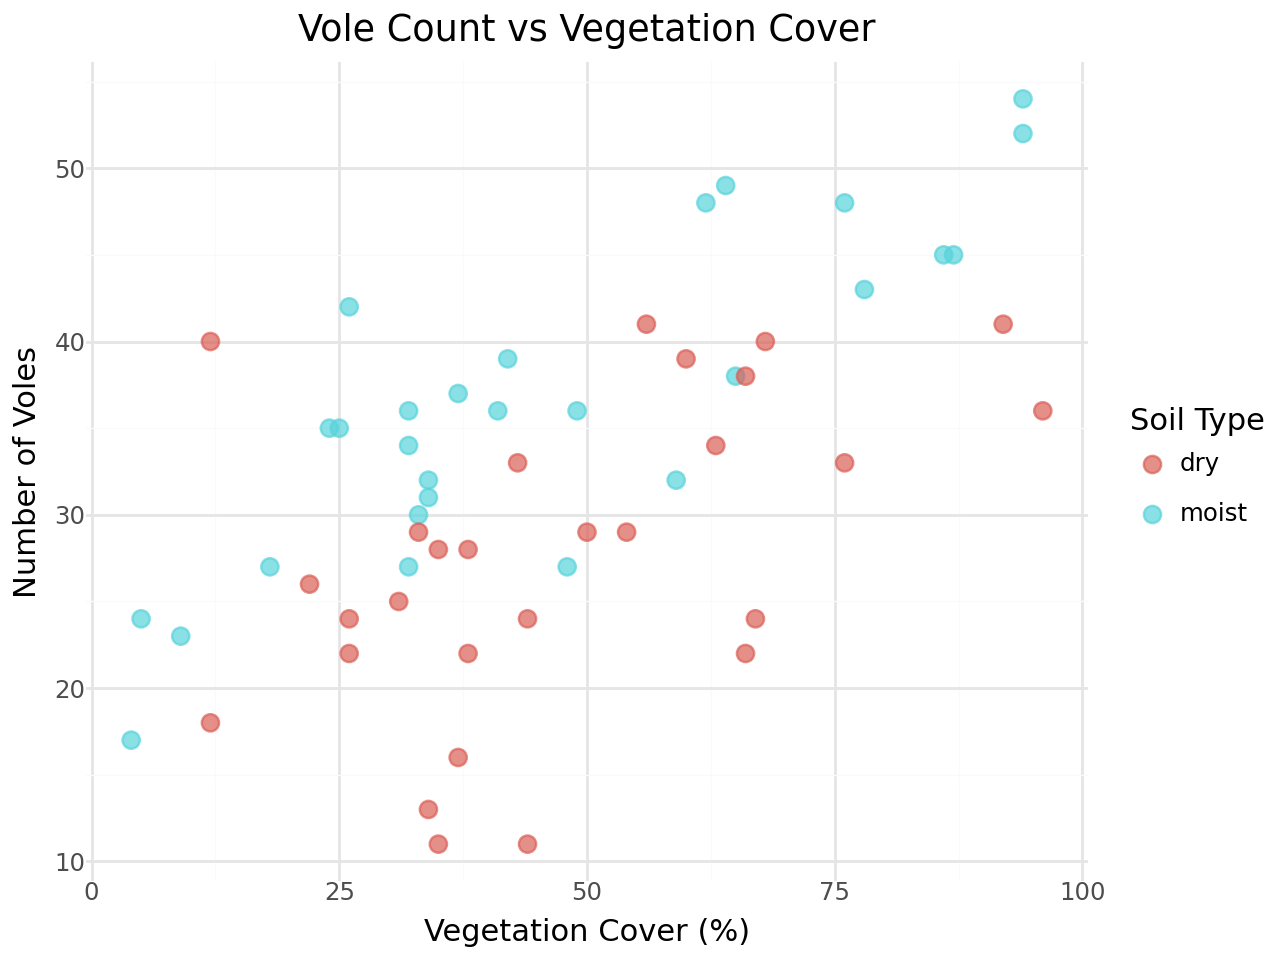

In [4]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

# Scatterplot: voles vs veg, colored by soil type
(ggplot(df_voles, aes(x="veg", y="voles", color="soil"))
    + geom_point(size=3, alpha=0.7)
    + labs(title="Vole Count vs Vegetation Cover", x="Vegetation Cover (%)", y="Number of Voles", color="Soil Type")
    + theme_minimal())

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [34]:
X = df_voles[["soil", "veg"]]
y = df_voles["voles"]

col_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["soil"]),
    remainder="passthrough")

pipeline = make_pipeline(
    col_transformer,
    LinearRegression())

pipeline.fit(X, y)




/home/studio-lab-user/.conda/envs/data730/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [23]:
def get_regression_table(pipeline):
    terms = list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)
regression_table = get_regression_table(pipeline)
print(regression_table)

                        term   estimate
0  onehotencoder__soil_moist   9.100298
1             remainder__veg   0.259069
2                  intercept  15.464026


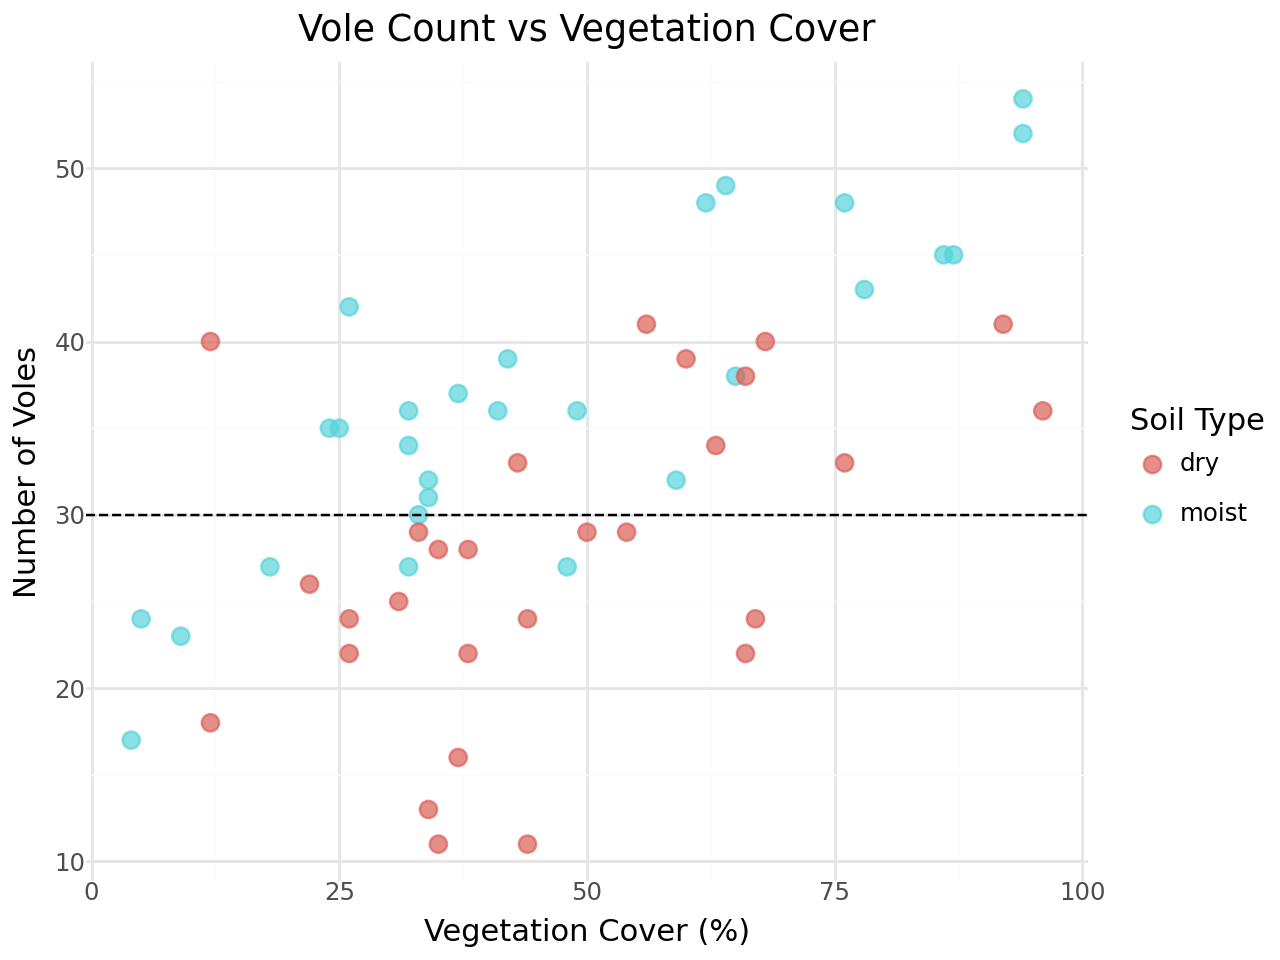

In [27]:
(
    ggplot(df_voles, aes(x="veg", y="voles", color="soil"))
    + geom_point(size=3, alpha=0.7)
    + geom_hline(yintercept=30, linetype="dashed", color="black")  # horizontal line at 30
    + labs(
        title="Vole Count vs Vegetation Cover",
        x="Vegetation Cover (%)",
        y="Number of Voles",
        color="Soil Type"
    )
    + theme_minimal()
)



In [33]:
prediction = pipeline.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

print("Predicted vole population:", prediction)

Predicted vole population: [34.92708151]


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

Yes, protecting a site with high vegetation cover would be more effective. The regression model shows a positive slope for vegetation cover (≈ 0.26), meaning vole counts rise as vegetation increases. This trend is consistent across soil types, so higher vegetation always supports more voles than lower vegetation.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

On dry sites, vegetation cover needs to be maintained at about 55–60% to support a vole population of roughly 30. This comes from the parallel slopes regression model, which shows that vole counts increase by about 0.26 for every 1% increase in vegetation cover. The scatterplot with the horizontal line at 30 voles confirms this estimate, showing that dry sites need considerably higher vegetation cover before vole populations reach this level.

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

The regression model predicts that a moist site with 40% vegetation cover would support 34 voles, as we cannot have a fraction of a vole with 34.93 voles.